### CNN on CIFR Assignment:

1.  Please visit this link to access the state-of-art DenseNet code for reference - DenseNet - cifar10 notebook link
2.  You need to create a copy of this and "retrain" this model to achieve 90+ test accuracy. 
3.  You cannot use DropOut layers.
4.  You MUST use Image Augmentation Techniques.
5.  You cannot use an already trained model as a beginning points, you have to initilize as your own
6.  You cannot run the program for more than 300 Epochs, and it should be clear from your log, that you have only used 300 Epochs
7.  You cannot use test images for training the model.
8.  You cannot change the general architecture of DenseNet (which means you must use Dense Block, Transition and Output blocks as mentioned in the code)
9.  You are free to change Convolution types (e.g. from 3x3 normal convolution to Depthwise Separable, etc)
10. You cannot have more than 1 Million parameters in total
11. You are free to move the code from Keras to Tensorflow, Pytorch, MXNET etc. 
12. You can use any optimization algorithm you need. 
13. You can checkpoint your model and retrain the model from that checkpoint so that no need of training the model from first if you lost at any epoch while training. You can directly load that model and Train from that epoch. 

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
from tensorflow.python.client import device_lib 
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6447702113979293328, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11345264640
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16374535067227115615
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [3]:
import os
root_path = '/content/gdrive/MyDrive/cifar-10'

In [4]:
import warnings 
warnings.filterwarnings("ignore")

In [5]:
# import keras
# from keras.datasets import cifar10
# from keras.models import Model, Sequential
# from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
# from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
# from keras.layers import Concatenate
# from keras.optimizers import Adam
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam

In [6]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf

In [8]:
# Hyperparameters
batch_size = 128
num_classes = 10
epochs = 30
l = 6
num_filter = 64
compression = 0.5
dropout_rate = 0

In [9]:
# Load CIFAR10 Data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]

# convert to one hot encoing 
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes) 

170508288/170498071 [==============================] - 2s 0us/step


In [10]:
X_train.shape

(50000, 32, 32, 3)

In [11]:
y_train.shape

(50000, 10)

In [12]:
X_test.shape

(10000, 32, 32, 3)

In [13]:
y_test.shape

(10000, 10)

##Data Augmentation:
- Data augmentation involves making copies of the examples in the training dataset with small random modifications.

- This has a regularizing effect as it both expands the training dataset and allows the model to learn the same general features, although in a more generalized manner.

In [18]:
#https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/
from keras.preprocessing.image import ImageDataGenerator
# define data preparation
# Using image augmentation techniques
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=12,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.15, # Randomly zoom image 
        width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(X_train)

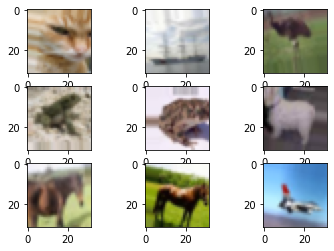

In [19]:
import matplotlib.pyplot as plt
import numpy as np
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
	# create a grid of 3x3 images
	for i in range(0, 9):
		plt.subplot(330 + 1 + i)
		plt.imshow(X_batch[i].astype(np.uint8))
	# show the plot
	plt.show()
	break

<pre><font size=5>Define: Dense Block , Transition Block , Output Block.

In [ ]:
# Dense Block
def denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
            Conv2D_3_3 = layers.Dropout(dropout_rate)(Conv2D_3_3)
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

## transition Blosck
def transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
         Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    cv = layers.Conv2D(14, (1,1), use_bias=False ,padding='same')(relu)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(cv)
    flat = layers.Flatten()(AvgPooling)
    output = layers.Dense(num_classes, activation='softmax')(flat)
    return output

<pre><font size=5>Define Model with some paramter.
- num_filter = 64
- l = 6
- Dropout_rate = 0
- Batch_size = 128

In [ ]:
num_filter = 64
dropout_rate = 0
l = 6
input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = transition(First_Block, num_filter, dropout_rate)

Second_Block = denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = transition(Second_Block, num_filter, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, num_filter, dropout_rate)

Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

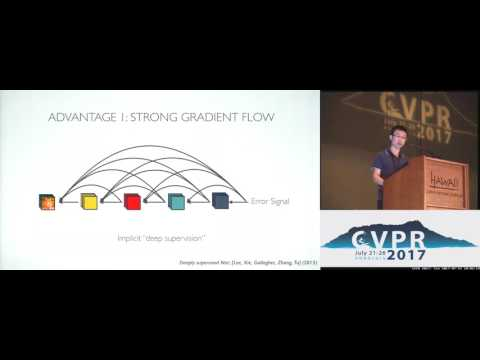

In [35]:
#https://arxiv.org/pdf/1608.06993.pdf
from IPython.display import IFrame, YouTubeVideo
YouTubeVideo(id='-W6y8xnd--U', width=600)

###Here's the complete architecture of your model:

In [ ]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   1728        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

As we seen Total parameter is less than 1 millon which satisfy our assignment condition, So we can processed next operation.

In [ ]:
print(f"Number of layers in model: {len(model.layers)}")

Number of layers in model: 116


In [ ]:
import warnings 
warnings.filterwarnings("ignore")

In [ ]:
import os
checkpoint_path = "/content/gdrive/MyDrive/cifar-10/cp1-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)


cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, verbose=1, save_weights_only=True)

###Compile the model

In [ ]:
from tensorflow.keras.optimizers import SGD
# compile model
opt = SGD(lr=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
steps_per_epoch = X_train.shape[0]//batch_size
steps_per_epoch

390

###Prepare Pixel Data
We know that the pixel values for each image in the dataset are unsigned integers in the range between no color and full color, or 0 and 255.

The prep_pixels() function below implement these behaviors and is provided with the pixel values for both the train and test datasets that will need to be scaled.

In [21]:
#https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/
# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

In [22]:
# prepare pixel data
X_train,X_test=prep_pixels(X_train,X_test)

###train the model

In [ ]:
#https://machinelearningmastery.com/check-point-deep-learning-models-keras/
from keras.callbacks import ModelCheckpoint

history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),steps_per_epoch=X_train.shape[0]//batch_size,
    epochs=epochs,
    verbose = 1,validation_steps = X_test.shape[0]//batch_size,
    validation_data=(X_test, y_test),callbacks=[cp_callback])

Epoch 1/30
390/390 [==============================] - 122s 312ms/step - loss: 1.6138 - accuracy: 0.4078 - val_loss: 2.2950 - val_accuracy: 0.2658

Epoch 00001: saving model to /content/gdrive/MyDrive/cifar-10/cp1-0001.ckpt
Epoch 2/30
390/390 [==============================] - 116s 298ms/step - loss: 1.3914 - accuracy: 0.4969 - val_loss: 1.9232 - val_accuracy: 0.3896

Epoch 00002: saving model to /content/gdrive/MyDrive/cifar-10/cp1-0002.ckpt
Epoch 3/30
390/390 [==============================] - 116s 298ms/step - loss: 1.2650 - accuracy: 0.5461 - val_loss: 1.4474 - val_accuracy: 0.4990

Epoch 00003: saving model to /content/gdrive/MyDrive/cifar-10/cp1-0003.ckpt
Epoch 4/30
390/390 [==============================] - 117s 298ms/step - loss: 1.1738 - accuracy: 0.5828 - val_loss: 1.5699 - val_accuracy: 0.4730

Epoch 00004: saving model to /content/gdrive/MyDrive/cifar-10/cp1-0004.ckpt
Epoch 5/30
390/390 [==============================] - 116s 298ms/step - loss: 1.1063 - accuracy: 0.6044 - va

In [ ]:
# Test the model
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 10s 30ms/step - loss: 0.8106 - accuracy: 0.7529
Test loss: 0.8105748295783997
Test accuracy: 0.7529000043869019


In [33]:
model.load_weights('/content/gdrive/MyDrive/cifar-10/cp1-0030.ckpt')

In [ ]:
# Save the trained weights in to .h5 format
model.save_weights("model_dense.h5")
print("Saved model to disk")

Saved model to disk


<pre><font size=4>As we seen above we get that we don't Get Good accuracy with This Parameter.
Now instead of using sgd we used Adam compiler with same parameter let's see what happend.
Adam compiler beacuse Adam is the best optimizers. If one wants to train the neural network in less time and more efficiently than Adam is the optimizer. 

In [ ]:
#checkpoints after 30th epoch
import os
checkpoint_path = "/content/gdrive/My Drive/densenet_training/cp1-30-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)


cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, verbose=1, save_weights_only=True)

In [ ]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [ ]:
#https://machinelearningmastery.com/check-point-deep-learning-models-keras/
from keras.callbacks import ModelCheckpoint

history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),steps_per_epoch=X_train.shape[0]//batch_size,
    epochs=20,
    verbose = 1,validation_steps = X_test.shape[0]//batch_size,
    validation_data=(X_test, y_test),callbacks=[cp_callback])

Epoch 1/20
390/390 [==============================] - 119s 297ms/step - loss: 0.8696 - accuracy: 0.6972 - val_loss: 1.5353 - val_accuracy: 0.5845

Epoch 00001: saving model to /content/gdrive/My Drive/densenet_training/cp1-30-0001.ckpt
Epoch 2/20
390/390 [==============================] - 115s 295ms/step - loss: 0.6996 - accuracy: 0.7579 - val_loss: 1.6346 - val_accuracy: 0.5609

Epoch 00002: saving model to /content/gdrive/My Drive/densenet_training/cp1-30-0002.ckpt
Epoch 3/20
390/390 [==============================] - 115s 295ms/step - loss: 0.6285 - accuracy: 0.7819 - val_loss: 1.7079 - val_accuracy: 0.5569

Epoch 00003: saving model to /content/gdrive/My Drive/densenet_training/cp1-30-0003.ckpt
Epoch 4/20
390/390 [==============================] - 115s 296ms/step - loss: 0.5761 - accuracy: 0.7995 - val_loss: 1.1977 - val_accuracy: 0.6701

Epoch 00004: saving model to /content/gdrive/My Drive/densenet_training/cp1-30-0004.ckpt
Epoch 5/20
390/390 [==============================] - 11

In [ ]:
model.load_weights('/content/gdrive/My Drive/densenet_training/cp1-30-0020.ckpt')

<pre><font size=4> Adam Give slightly Good output As compare to Sgd but we can't our expected output , so we have to it again.



In [ ]:
#checkpoints after 50th epoch
import os
checkpoint_path = "/content/gdrive/My Drive/densenet_training/cp1-50-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)


cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, verbose=1, save_weights_only=True)

In [ ]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [ ]:
#https://machinelearningmastery.com/check-point-deep-learning-models-keras/
from keras.callbacks import ModelCheckpoint

history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),steps_per_epoch=X_train.shape[0]//batch_size,
    epochs=20,
    verbose = 1,validation_steps = X_test.shape[0]//batch_size,
    validation_data=(X_test, y_test),callbacks=[cp_callback])

Epoch 1/20
390/390 [==============================] - 153s 301ms/step - loss: 0.2897 - accuracy: 0.9002 - val_loss: 0.4589 - val_accuracy: 0.8526

Epoch 00001: saving model to /content/gdrive/My Drive/densenet_training/cp1-50-0001.ckpt
Epoch 2/20
390/390 [==============================] - 113s 289ms/step - loss: 0.2866 - accuracy: 0.8999 - val_loss: 0.5989 - val_accuracy: 0.8117

Epoch 00002: saving model to /content/gdrive/My Drive/densenet_training/cp1-50-0002.ckpt
Epoch 3/20
390/390 [==============================] - 113s 289ms/step - loss: 0.2787 - accuracy: 0.9039 - val_loss: 0.6315 - val_accuracy: 0.8153

Epoch 00003: saving model to /content/gdrive/My Drive/densenet_training/cp1-50-0003.ckpt
Epoch 4/20
390/390 [==============================] - 113s 289ms/step - loss: 0.2761 - accuracy: 0.9031 - val_loss: 0.5167 - val_accuracy: 0.8404

Epoch 00004: saving model to /content/gdrive/My Drive/densenet_training/cp1-50-0004.ckpt
Epoch 5/20
390/390 [==============================] - 11

In [ ]:
model.load_weights('/content/gdrive/My Drive/densenet_training/cp1-50-0020.ckpt')

<pre><font size=5>NOT GET OUR EXPECTED RESULT , WE HAVE TO GO AGAIN.

In [ ]:
#checkpoints after 70th epoch
import os
checkpoint_path = "/content/gdrive/My Drive/densenet_training/cp1-70-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)


cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, verbose=1, save_weights_only=True)

In [ ]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [ ]:
#https://machinelearningmastery.com/check-point-deep-learning-models-keras/
from keras.callbacks import ModelCheckpoint

history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),steps_per_epoch=X_train.shape[0]//batch_size,
    epochs=20,
    verbose = 1,validation_steps = X_test.shape[0]//batch_size,
    validation_data=(X_test, y_test),callbacks=[cp_callback])

Epoch 1/20
390/390 [==============================] - 117s 293ms/step - loss: 0.1902 - accuracy: 0.9324 - val_loss: 0.4018 - val_accuracy: 0.8796

Epoch 00001: saving model to /content/gdrive/My Drive/densenet_training/cp1-70-0001.ckpt
Epoch 2/20
390/390 [==============================] - 113s 290ms/step - loss: 0.1850 - accuracy: 0.9344 - val_loss: 0.5467 - val_accuracy: 0.8474

Epoch 00002: saving model to /content/gdrive/My Drive/densenet_training/cp1-70-0002.ckpt
Epoch 3/20
390/390 [==============================] - 113s 290ms/step - loss: 0.1842 - accuracy: 0.9350 - val_loss: 0.5025 - val_accuracy: 0.8507

Epoch 00003: saving model to /content/gdrive/My Drive/densenet_training/cp1-70-0003.ckpt
Epoch 4/20
390/390 [==============================] - 113s 290ms/step - loss: 0.1769 - accuracy: 0.9382 - val_loss: 0.4173 - val_accuracy: 0.8751

Epoch 00004: saving model to /content/gdrive/My Drive/densenet_training/cp1-70-0004.ckpt
Epoch 5/20
390/390 [==============================] - 11

In [ ]:
model.load_weights('/content/gdrive/My Drive/densenet_training/cp1-70-0014.ckpt')

In [ ]:
# Test the model
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 10s 30ms/step - loss: 0.3428 - accuracy: 0.9000
Test loss: 0.3428269028663635
Test accuracy: 0.8999999761581421


<pre><font size=5>Here we get our output at 84 epoch.
We Run it again and see it give even good result .

In [ ]:
model.load_weights('/content/gdrive/My Drive/densenet_training/cp1-70-0020.ckpt')

In [ ]:
#checkpoints after 90 epoch
import os
checkpoint_path = "/content/gdrive/My Drive/densenet_training/cp1-90-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)


cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, verbose=1, save_weights_only=True)

In [ ]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [ ]:
#https://machinelearningmastery.com/check-point-deep-learning-models-keras/
from keras.callbacks import ModelCheckpoint

history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),steps_per_epoch=X_train.shape[0]//batch_size,
    epochs=20,
    verbose = 1,validation_steps = X_test.shape[0]//batch_size,
    validation_data=(X_test, y_test),callbacks=[cp_callback])

Epoch 1/20
390/390 [==============================] - 117s 291ms/step - loss: 0.1413 - accuracy: 0.9503 - val_loss: 0.4049 - val_accuracy: 0.8886

Epoch 00001: saving model to /content/gdrive/My Drive/densenet_training/cp1-90-0001.ckpt
Epoch 2/20
390/390 [==============================] - 113s 289ms/step - loss: 0.1340 - accuracy: 0.9524 - val_loss: 0.3920 - val_accuracy: 0.8902

Epoch 00002: saving model to /content/gdrive/My Drive/densenet_training/cp1-90-0002.ckpt
Epoch 3/20
390/390 [==============================] - 113s 289ms/step - loss: 0.1343 - accuracy: 0.9518 - val_loss: 0.3937 - val_accuracy: 0.8930

Epoch 00003: saving model to /content/gdrive/My Drive/densenet_training/cp1-90-0003.ckpt
Epoch 4/20
390/390 [==============================] - 113s 289ms/step - loss: 0.1305 - accuracy: 0.9540 - val_loss: 0.4057 - val_accuracy: 0.8836

Epoch 00004: saving model to /content/gdrive/My Drive/densenet_training/cp1-90-0004.ckpt
Epoch 5/20
390/390 [==============================] - 11

In [ ]:
model.load_weights('/content/gdrive/My Drive/densenet_training/cp1-90-0011.ckpt')

In [ ]:
# Test the model
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 9s 29ms/step - loss: 0.3680 - accuracy: 0.9017
Test loss: 0.36804988980293274
Test accuracy: 0.9017000198364258


In [23]:
model.load_weights('/content/gdrive/My Drive/densenet_training/cp1-90-0020.ckpt')

<pre><font size=5>Now instead of Adam we used Sgd and see how it give result.

In [24]:
#checkpoints after 90 epoch
import os
checkpoint_path = "/content/gdrive/My Drive/densenet_training/cp1-110-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)


cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, verbose=1, save_weights_only=True)

In [25]:
# determine Loss function and Optimizer
from tensorflow.keras.optimizers import SGD
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=0.1, decay=1e-4, momentum=0.9, nesterov=True),
              metrics=['accuracy'])

In [26]:
#https://machinelearningmastery.com/check-point-deep-learning-models-keras/
from keras.callbacks import ModelCheckpoint

history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),steps_per_epoch=X_train.shape[0]//batch_size,
    epochs=20,
    verbose = 1,validation_steps = X_test.shape[0]//batch_size,
    validation_data=(X_test, y_test),callbacks=[cp_callback])

Epoch 1/20
390/390 [==============================] - 153s 303ms/step - loss: 0.0920 - accuracy: 0.9675 - val_loss: 0.2944 - val_accuracy: 0.9202

Epoch 00001: saving model to /content/gdrive/My Drive/densenet_training/cp1-110-0001.ckpt
Epoch 2/20
390/390 [==============================] - 113s 290ms/step - loss: 0.0812 - accuracy: 0.9708 - val_loss: 0.2892 - val_accuracy: 0.9224

Epoch 00002: saving model to /content/gdrive/My Drive/densenet_training/cp1-110-0002.ckpt
Epoch 3/20
390/390 [==============================] - 113s 290ms/step - loss: 0.0814 - accuracy: 0.9716 - val_loss: 0.2857 - val_accuracy: 0.9227

Epoch 00003: saving model to /content/gdrive/My Drive/densenet_training/cp1-110-0003.ckpt
Epoch 4/20
390/390 [==============================] - 113s 289ms/step - loss: 0.0757 - accuracy: 0.9731 - val_loss: 0.2891 - val_accuracy: 0.9216

Epoch 00004: saving model to /content/gdrive/My Drive/densenet_training/cp1-110-0004.ckpt
Epoch 5/20
390/390 [==============================] 

In [27]:
# Test the model
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 10s 31ms/step - loss: 0.2825 - accuracy: 0.9245
Test loss: 0.28252753615379333
Test accuracy: 0.9244999885559082


<pre><font size=5>we get our Best output at 110 epoch , which 92.45 accuracy.

In [32]:
# Save the trained weights in to .h5 format
model.save_weights("model_dense.h5")
print("Saved model to disk")

Saved model to disk


#Conclusion:

After using some image augmentation techniques like rotation,horizontal flipping, height and width shifting, as well as changing some hyperparameters, we were able to get a model with 92.45% test accuracy. Our deep learning model has less than 1 Million parameters, and we have reached the desired accuracy in less than 300 epochs.

#Refernce:
- https://colab.research.google.com/drive/1NGQjke72AS93IOpNcnE9diQEg78-sU3C#scrollTo=c5Wksy8z5-rw.
- https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/
- https://www.tensorflow.org/tutorials/images/cnn